# Numerical Illustrations (Linear)
Setup inspired by Avella-Medina (2017).

(https://projecteuclid.org/journals/bernoulli/volume-23/issue-4B/Influence-functions-for-penalized-M-estimators/10.3150/16-BEJ841.full)

We will use a linear model which we solve using penalized ridge regression to illustrate the statistical influence function bound proven in this paper. 

## Linear Design

We simulate a model $y_i = x_i^T\theta + \mu_i$ for $n=[15, 10000]$. Each $x_i$ is iid standard normal random variables and $\theta^\star \in \mathbb{R}^9$ is fixed ahead of time. In order to introduce contaimination into the dataset, we let $\mu_i = (1-b_i)N(0,1)+b_iN(0,10)$ and $b_i\sim \text{Bernoulli}(.1)$.

For our analysis we use the following notation:

$\ell(z,\theta)= (y - x^T\theta) + \lambda \theta^T \theta$ is the loss function

$H_\star = \nabla_{\theta_\star}^2 \ell (\theta_\star)$ is the population Hessian

$H_n(\theta_n) := \frac{1}{n} \sum_{i=1}^n \nabla_{\theta_n}^2 \ell(z_i, \theta_n)$ is the estimate of the Hessian

$\theta_n$ is calculated using ridge regression


In [17]:
import numpy as np
import pandas as pd
from utils import run_sim_lin, generate_theta_star_lin

# Generate theta*
dim = 9
theta_star = generate_theta_star_lin(dim)

# Find `oracle_theta` for the Ridge problem

We have $\theta^\star = (E[x x^\top]  + \lambda I)^{-1} E[yx]$. 

But our data generation satisfies $y = x^\top \theta_\star + \epsilon$ so that 
$$
    E[yx] = E[xx^\top] \theta_\star + E[x\epsilon] = H \theta_\star \,.
$$

Therefore, 
$$
    \theta^\star = (H  + \lambda I)^{-1} H \theta_\star = \frac{1/p^2}{1/p^2 + \lambda} \theta_\star ,
$$
since $H = (1 / p^2) I$ in our case. "
   

In [18]:
# Find oracle theta for linear regression
def find_oracle_theta_lin(dim, lambda_):
    return 1 / (1 + lambda_ * dim * dim) * theta_star

# Population Influence Function for Ridge Regression
We will use the following closed form solution for the population influence function provided by Cook and Weisberg (1982).

$I(z)= -H_\star^{-1}\nabla \ell(z,\theta_\star)$

where $z=(x,y), x\sim N(0,1), \mu \sim N(0,10), y = x^T\theta^\star + \mu$

We define the following:

$H_\star =  diag(\frac{1}{p^2} + \lambda)$ , where $p$ is dimension of $\theta$

$\nabla \ell(z,\theta_\star) = -(y-x^T\theta_\star)x +\lambda\theta_\star$



In [19]:
# Population Influence Function for Linear Regression
def if_orth_pop(dim, x_con, y_con, oracle_theta, lambda_):
    hess = np.eye(dim) * (1 / dim**2 + lambda_)  # H = (1/d^2) I in our case
    grad = (np.dot(x_con, oracle_theta) - y_con) * x_con + np.sum(lambda_ * oracle_theta)
    return -np.linalg.solve(hess, grad)

# Empirical Influence Function for Ridge Regression
We will use the following closed form solution for the empirical influence function provided by Cook and Weisberg (1982).

$I_n(z)= -H_n(\theta_n)^{-1}\nabla \ell(z,\theta_n)$

where $z=(x,y), x\sim N(0,1), \mu \sim N(0,10), y = x^T\theta^\star + \mu$

We define the following:

$H_n(\theta_n) = \frac1n \sum_{i=1}^n x_ix_i^T + \lambda_I$ 

$\nabla \ell(z,\theta_n) = -(y-x^T\theta_n)x + \lambda\theta_n$

$\theta_n$ is calculated using ridge regression

In [20]:
# Finding theta values using Ridge regression 
def ridge(x, y, lambda_):
    hess = np.matmul(x.T, x) + lambda_ * np.eye(x.shape[1])  
    grad = np.matmul(x.T, y) 
    return np.linalg.solve(hess, grad)  

# Empirical Influence Function for Linear Regression
def if_orth_emp(x_sim, y_sim, x_con, y_con, lambda_, n):
    ridge_theta = ridge(x_sim, y_sim, lambda_)
    hess = np.matmul(x_sim.T, x_sim) / n + lambda_ * np.eye(x_sim.shape[1])
    grad = (np.dot(x_con, ridge_theta) - y_con) * x_con+ np.sum(lambda_ * ridge_theta)
    return -np.linalg.solve(hess, grad)


## Run Simulations
We now calculate the difference between the empirical influence and population influence of $100$ simulated contamination datapoint using different training data sample sizes ($n = 15, 55, 202, 742, 2724, 10000$). We consider different penalization parameter values $\lambda = 1e-4, 1e-3, 1e-2$. 


In [21]:
# Run simulation
eps = .1
lambda_ls = [1e-4, 1e-3, 1e-2]
n_ls = list(np.logspace(np.log10(15),np.log10(10000), 6).astype(int))
n_sim = 100
seed = 1
oracle_theta_dict = {l : find_oracle_theta_lin(dim, l) for l in lambda_ls}

mean_diff_abs_total, sd_diff_abs_total, n_samp, lambda_ = run_sim_lin(n_sim, eps, n_ls, lambda_ls, oracle_theta_dict, dim, seed, theta_star, if_orth_emp, if_orth_pop)
bound_val_results = pd.DataFrame({"mean_diff_abs":mean_diff_abs_total, "n":n_samp,"lambda":lambda_,"sd_diff_abs":sd_diff_abs_total})


## Calculate Statistical Bound (Theorem 1)
We calculate the bound from Theorem 1 without coefficients using the following equations. 

$\|I_n(z) - I(z)\|_{H_\star}^2 \leq \frac{p_\star^2}{\mu_\star n} log(\frac p\delta)^3$

where, $p_\star = \text{Tr}\bigg [H_\star^{-1/2}G_\star H_\star^{-1/2} \bigg] = \text{Tr}\bigg [H_\star^{-1}G_\star\bigg ]$

In [22]:
def stat_bound(p_star, mu_star,n,delta):
    return((p_star**2)/((mu_star)*n)*np.log(p/delta)**3)

# Calculate statistical bound for each lambda value   
p = 9
lambda_ls = [1e-4, 1e-3, 1e-2]
stat_bound_ls={}
delta = .05
for l in lambda_ls:
    hess_pop = np.eye(dim) * (1 / dim**l)
    mu_star = np.min(np.linalg.eig(hess_pop)[0])
    n_ls = bound_val_results.loc[bound_val_results['lambda']== l]['n']
    stat_bound_ls[l]=stat_bound(p,mu_star,n_ls,delta)

## Graph Results
We only graph results for $\lambda_{} = 1e-3$

In [23]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['lines.markersize'] = 12
shape = ["o","X", "s","^", "P"]
line = ["solid", "dotted", "dashed", "dashdot","loosely dotted"]
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']


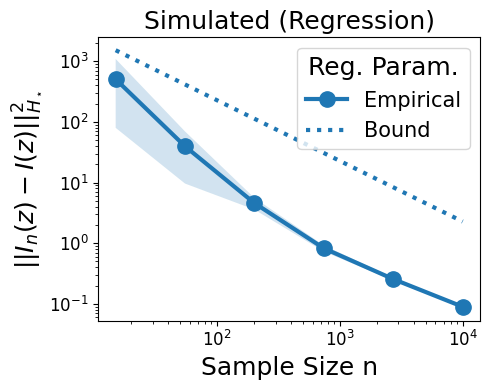

In [24]:
# Graph Results
import pandas as pd
bound_val_results = pd.DataFrame({"mean_diff_abs":mean_diff_abs_total, "n":n_samp,"lambda":lambda_,"sd_diff_abs":sd_diff_abs_total})
lambda_ls_name = [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"]
lambda_ls = [1e-3]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
for i, l in enumerate(lambda_ls):
    data = bound_val_results.loc[bound_val_results['lambda']== l]
    ax.plot(np.abs(data['n']),np.abs(data['mean_diff_abs']),label = "Empirical", color = COLORS[i], marker = shape[i], linestyle = line[i], markersize = 11)
    ax.fill_between(np.abs(data['n']), np.abs(data['mean_diff_abs']-1.96*data['sd_diff_abs']/np.sqrt(data['n'])), np.abs(data['mean_diff_abs']+1.96*data['sd_diff_abs']/np.sqrt(data['n'])), alpha=0.2)
    # We scale the statistical bound by a constant of 2
    ax.plot(np.abs(data['n']), 2*stat_bound_ls[l], color = COLORS[i], linestyle = line[1],label = "Bound")

ax.set_ylabel(r'$\|\| I_{n}(z) - I(z) \|\|_{H_\star}^2$')
ax.set_xlabel("Sample Size n")
ax.set_title('Simulated (Regression)')
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc='upper right', borderpad=.15, labelspacing=.2)

plt.legend(loc='upper right', title='Reg. Param.', title_fontsize = 18)
plt.tight_layout()